# Proyek Klasifikasi Gambar: Weather
- **Nama:** I Kadek Adi Memes Subagia
- **Email:** adumemes06@gmail.com
- **ID Dicoding:** adimemes

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files



import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

local_zip = '/content/drive/MyDrive/Weather.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [4]:
base_dir='/content/Weather'
groups=os.listdir(base_dir)
for group in groups:
    print('No of images in ',group ,'is ',len(os.listdir(os.path.join(base_dir,group))))

No of images in  Sunrise is  824
No of images in  Cloudy is  704
No of images in  Shine is  606
No of images in  Rain is  502


In [5]:
from PIL import Image

def display_images(class_name,num_images=5):
    class_dir=os.path.join(base_dir,class_name)
    images=os.listdir(class_dir)[:num_images]

    plt.figure(figsize=(15,30))
    for i,img_name in enumerate(images):
        img_path=os.path.join(class_dir,img_name)
        img=Image.open(img_path)
        plt.subplot(1,num_images,i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

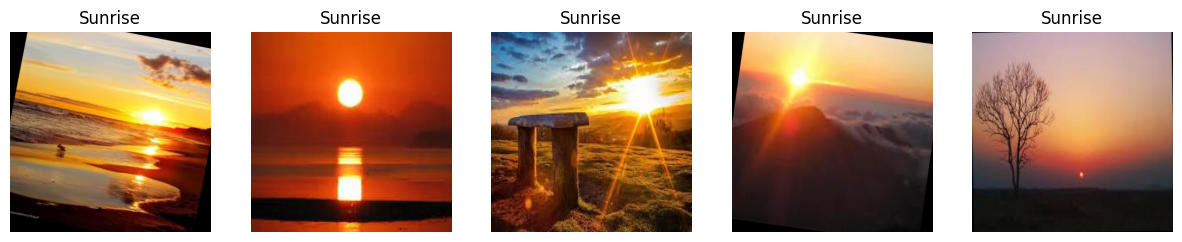

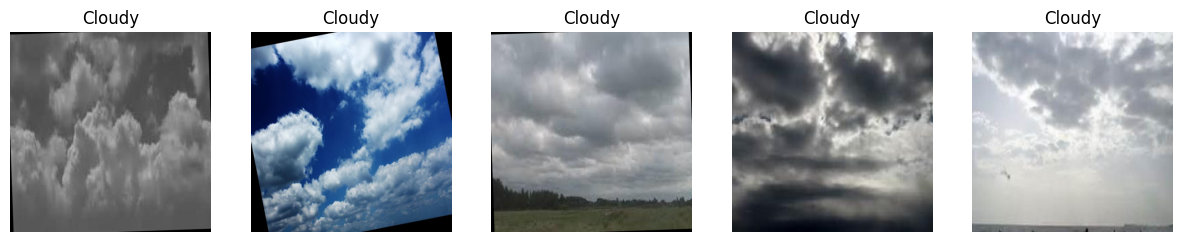

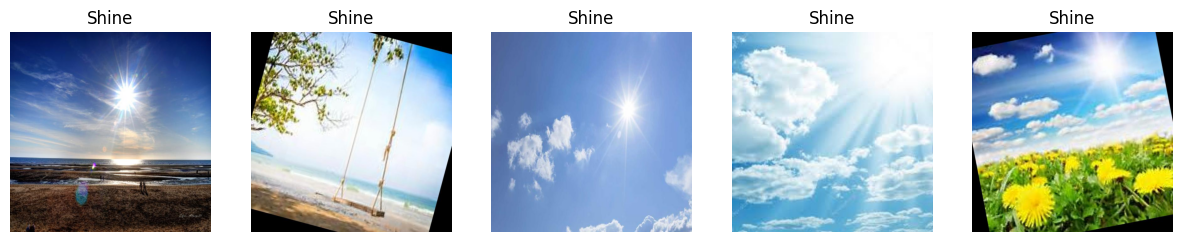

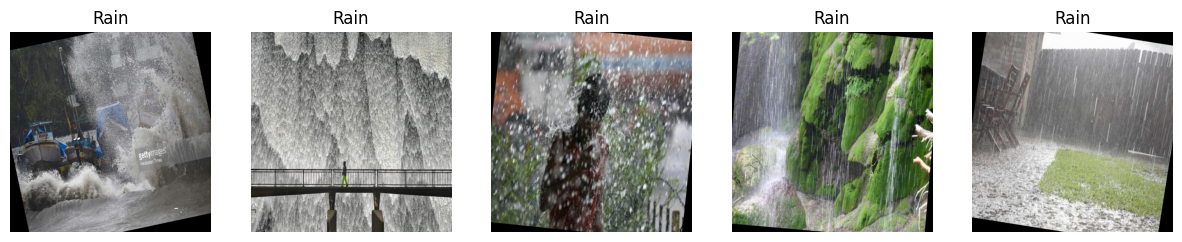

In [6]:
for group in groups:
    display_images(group,5)

In [7]:
data=[]

for label in groups:
    label_path=os.path.join(base_dir,label)
    for img_name in os.listdir(label_path):
        img_path=os.path.join(label_path,img_name)
        data.append({'image_path':img_path,'label':label})


data=pd.DataFrame(data)
data.sample(10)

,image_path,label
2482,/content/Weather/Rain/rain138_jpg.rf.ab1d2a508...,Rain
1970,/content/Weather/Shine/shine228_jpg.rf.9e8986d...,Shine
2500,/content/Weather/Rain/rain201_jpg.rf.1fb196880...,Rain
1053,/content/Weather/Cloudy/cloudy232_jpg.rf.7400a...,Cloudy
2443,/content/Weather/Rain/rain129_jpg.rf.a40e53360...,Rain
1510,/content/Weather/Cloudy/cloudy294_jpg.rf.70b9a...,Cloudy
1760,/content/Weather/Shine/shine166_jpg.rf.1dce5cd...,Shine
1305,/content/Weather/Cloudy/cloudy133_jpg.rf.b3e73...,Cloudy
420,/content/Weather/Sunrise/sunrise170_jpg.rf.32b...,Sunrise
373,/content/Weather/Sunrise/sunrise227_jpg.rf.4be...,Sunrise


In [8]:
data.shape

(2636, 2)

### Data Preprocessing

#### Split Dataset

In [9]:
from sklearn.model_selection import train_test_split
train_data,temp_data=train_test_split(data,test_size=0.3,stratify=data['label'],random_state=42)
val_data,test_data=train_test_split(temp_data,test_size=0.33,stratify=temp_data['label'],random_state=42)

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1845, 2)
(262, 2)
(529, 2)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1845 validated image filenames belonging to 4 classes.
Found 529 validated image filenames belonging to 4 classes.
Found 262 validated image filenames belonging to 4 classes.


## Modelling

In [11]:
# Load base model MobileNetV2
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,594,820 (21.34 MB)

 Trainable params: 3,335,940 (12.73 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nAkurasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[callbacks]
)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.5272 - loss: 1.0908 - val_accuracy: 0.8922 - val_loss: 0.2769
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8844 - loss: 0.3297 - val_accuracy: 0.9376 - val_loss: 0.2230
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9078 - loss: 0.2606 - val_accuracy: 0.9414 - val_loss: 0.1790
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9275 - loss: 0.2023 - val_accuracy: 0.9660 - val_loss: 0.1204
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9480 - loss: 0.1625 - val_accuracy: 0.9584 - val_loss: 0.1268
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9469 - loss: 0.1887 - val_accuracy: 0.9622 - val_loss: 0.1006
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9548 - loss: 0.1568
Akurasi telah mencapai >95%!
58/58 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9547 - loss: 0.1567 - val_accuracy: 0.9679 - val_loss: 0.1258


## Evaluasi dan Visualisasi

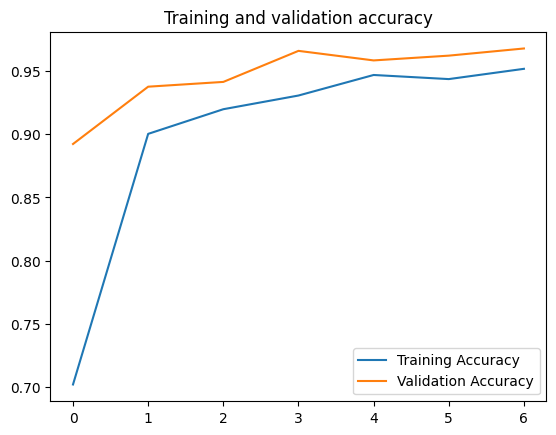

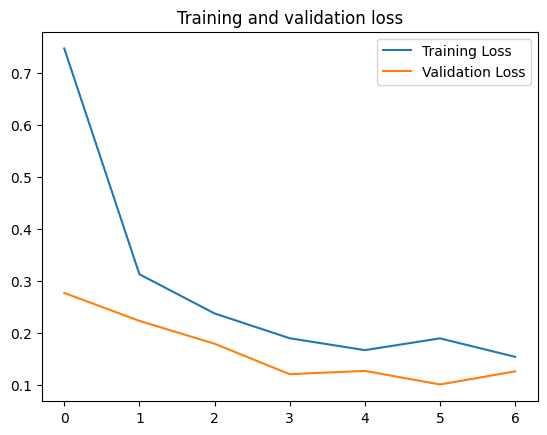

In [14]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc))


plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [15]:
loss, accuracy = model.evaluate(test_generator)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9673 - loss: 0.0709
Test loss: 0.08822690695524216
Test accuracy: 0.9618320465087891


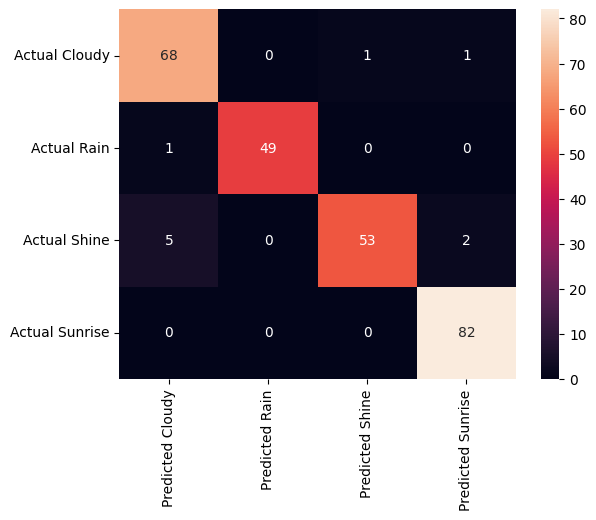



              precision    recall  f1-score   support

      Cloudy     0.9189    0.9714    0.9444        70
        Rain     1.0000    0.9800    0.9899        50
       Shine     0.9815    0.8833    0.9298        60
     Sunrise     0.9647    1.0000    0.9820        82

    accuracy                         0.9618       262
   macro avg     0.9663    0.9587    0.9616       262
weighted avg     0.9630    0.9618    0.9615       262



In [16]:
test_generator.reset()

preds_proba = model.predict(test_generator, verbose=0)

preds_classes = np.argmax(preds_proba, axis=1)

class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
true_classes = test_generator.classes

cm = pd.DataFrame(data=confusion_matrix(true_classes, preds_classes),
                  index=[f"Actual {name}" for name in class_names],
                  columns=[f"Predicted {name}" for name in class_names])
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("\n")
print(classification_report(y_true=true_classes, y_pred=preds_classes, target_names=class_names, digits=4))

Saving th.jpg to th.jpg
File diunggah: th.jpg


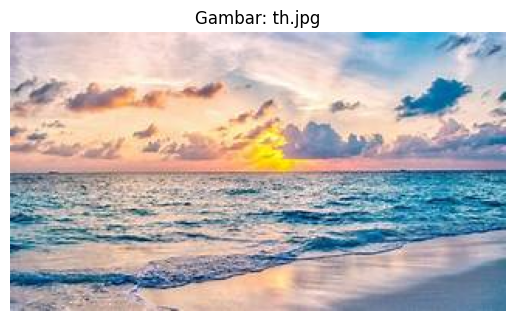

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Gambar yang diunggah diprediksi sebagai: 99.27% Sunrise


In [17]:
import numpy as np

def preprocess_image(image_path, target_size):
    from tensorflow.keras.utils import load_img, img_to_array
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi
    return img_array

# Define class names - This list was defined in a previous cell and maps indices to labels
class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

# Tetapkan threshold confidence
threshold = 0.7  # 70%

# Unggah file
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f"File diunggah: {file_name}")
    image_path = file_name

    # Tampilkan gambar
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Gambar: {file_name}")
    plt.show()

    # Preprocessing gambar
    image = preprocess_image(image_path, target_size=(224, 224))

    # Prediksi menggunakan model
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_probability = predictions[0][predicted_class_index]  # Confidence

    # Gunakan class_names list untuk mendapatkan label berdasarkan indeks
    predicted_label = class_names[predicted_class_index]

    # Logika untuk threshold confidence
    if predicted_probability < threshold:
        print("Hasil: Tidak Dikenali")
    else:
        print(f"Gambar yang diunggah diprediksi sebagai: {predicted_probability * 100:.2f}% {predicted_label}")

## Konversi Model

In [18]:
model.save("model.h5")

In [19]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-30 14:05:16.903867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748613916.929237   35490 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

In [20]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Import the pathlib module
import pathlib

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

218372

In [21]:

save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

## Inference (Optional)